In [62]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
import optuna

# Set style
plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [63]:

class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')
        df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'}, inplace=True)
        df.drop(['dteday', 'instant'], axis=1, inplace=True)

        # Creating time-based features
        df['payday'] = df['timestamp'].dt.is_month_end.astype(int)
        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day_of_year
        df['day_of_week'] = df['timestamp'].dt.day_of_week
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)
        df['quarter'] = df['timestamp'].dt.quarter
        df['christmas'] = df['timestamp'].apply(lambda x: 1 if x.month == 12 and x.day >= 20 else 0)
        df['day_of_year'] = df['timestamp'].dt.dayofyear

        # Creating rush hour feature
        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 4 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 21)) and x['working_day'] == 1 else 0, axis=1)

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df.drop_duplicates()
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        # Average ratios for different time-based groupings
        average_hour_ratio = train_df.groupby('hour').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_day_ratio = train_df.groupby('day_of_week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_week_ratio = train_df.groupby('week').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_month_ratio = train_df.groupby('month').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_season_ratio = train_df.groupby('season').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_weekend_ratio = train_df.groupby('weekend').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))
        average_working_day_ratio = train_df.groupby('working_day').apply(lambda x: x['registered'].sum() / (x['casual'].sum() or 1))

        # Applying ratios to both train and validation sets
        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['day_of_week'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['day_of_week'].map(average_day_ratio)

        # Now use these ratios wherever needed for working day and weekend conditions
        train_df['working_day_or_weekend_ratio'] = train_df['working_day'].map(average_working_day_ratio).where(train_df['working_day'] == 1, 
                                                                                                                        train_df['weekend'].map(average_weekend_ratio))
        val_df['working_day_or_weekend_ratio'] = val_df['working_day'].map(average_working_day_ratio).where(val_df['working_day'] == 1, 
                                                                                                                    val_df['weekend'].map(average_weekend_ratio))

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        # Dropping original target columns
        train_df.drop(['casual', 'registered'], axis=1, inplace=True)
        val_df.drop(['casual', 'registered'], axis=1, inplace=True)

        # Aggregate counts to daily level
        daily_train_df = train_df.groupby(['year', 'month', 'day', 'day_of_year'])[['count']].sum().reset_index()


        # Calculate rolling mean and standard deviation (2-week window)
        rolling_mean = daily_train_df['count'].rolling(window=14, center=True).mean()
        rolling_std = daily_train_df['count'].rolling(window=14, center=True).std()

        # Identify 3-sigma outliers
        daily_train_df['sigma_3_outlier'] = (daily_train_df['count'] > rolling_mean + 3 * rolling_std) | \
                                            (daily_train_df['count'] < rolling_mean - 3 * rolling_std)

        # Find max outlier flag per day_of_year
        day_of_year_outlier = daily_train_df.groupby('day_of_year', as_index=False)['sigma_3_outlier'].max()

        # Merge back into train_df and val_df
        train_df = train_df.merge(day_of_year_outlier, on='day_of_year', how='left')
        val_df = val_df.merge(day_of_year_outlier, on='day_of_year', how='left')

        # Fill NaN values (if no outlier was detected for that day, assume False)
        train_df['sigma_3_outlier'].fillna(False, inplace=True)
        val_df['sigma_3_outlier'].fillna(False, inplace=True)


        return train_df.drop_duplicates(), val_df.drop_duplicates()

        

        return train_df.drop_duplicates(), val_df.drop_duplicates()
    
    def split_and_engineer_data(self, df):
        sorted_df = df.sort_values('timestamp').copy()
        sorted_df.drop('timestamp', axis=1, inplace=True)

        train_df, val_df = train_test_split(sorted_df, test_size=0.2, shuffle=False)

        train_df, val_df = self.feature_engineering(train_df, val_df)

        return train_df, val_df


In [64]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from /Users/lawrence/Documents/PYTHON/saga_tech_test_2025/hour.csv


In [65]:
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3017/1637802544.py:64: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3017/1637802544.py:65: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3017/1637802544.py:66: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

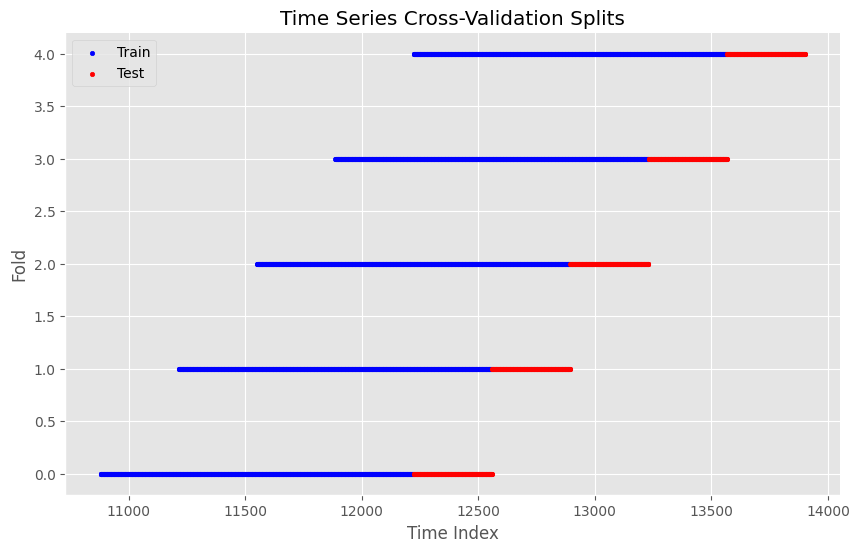

In [66]:
n_samples = len(train_df)

tcsv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=int(24 * 14 / 0.2 * 0.8),
    test_size=int(24 * 14),
)

fig, ax = plt.subplots(figsize=(10, 6))

for i, (train_idx, test_idx) in enumerate(tcsv.split(np.arange(n_samples))):
    ax.scatter(train_idx, [i] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
    ax.scatter(test_idx, [i] * len(test_idx), color="red", label="Test" if i == 0 else "", s=10)

ax.set_xlabel("Time Index")
ax.set_ylabel("Fold")
ax.set_title("Time Series Cross-Validation Splits")
ax.legend()
sns.despine()
plt.show()

In [67]:
transformer = QuantileTransformer(output_distribution='normal')

features_in_importance_order = ['hour', 'atemp' , 'temp', 'year', 'rush_hour', 
                                'working_day', 'weathersit', 'day_of_week', 'day', 'hum', 'day_of_year', 
                                'day_ratio', 'season', 'week_ratio', 'month_cos', 'weekend', 
                                'windspeed', 'week', 'working_day_or_weekend_ratio', 'holiday', 
                                'moonphase']

target = 'count'

numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'month_cos', 
                    'moonphase', 'hour_ratio', 
                   'day_ratio', 'week_ratio', 'working_day_or_weekend_ratio']

categorical_label_encode_columns = ['season', 'year', 'month', 'hour', 'day_of_week', 'weathersit','day', 'week']

categorical_one_hot_columns = ['holiday', 'working_day', 'weekend', 'rush_hour']

features = numeric_columns + categorical_label_encode_columns + categorical_one_hot_columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns)
    ],
    remainder='drop',
    n_jobs=-1
)

X_train = train_df[features]
y_train = train_df[target]

In [68]:
import json

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 10.0, log=True),
        'verbosity': -1
    }
    
        
    lgbm_regressor = lgb.LGBMRegressor(**params, verbose=-1)

    # Create the transformed target regressor
    transformed_regressor = TransformedTargetRegressor(
        regressor=lgbm_regressor,
        transformer=transformer
    )
    
    # Create the full pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', transformed_regressor)
    ])
    
    # Perform cross-validation using time series split
    cv_results = cross_val_score(
        pipe, 
        X_train, 
        y_train, 
        cv=tcsv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
    )
    
    # Return the mean negative RMSE
    return -np.mean(cv_results)

study = optuna.create_study(direction='minimize')

n_trials = 1000
study.optimize(objective, n_trials=n_trials)

with open('best_lgbm_params.json', 'w') as f:
    json.dump(study.best_params, f, indent=4)

print(f"Best parameters: {study.best_params}")
print(f"Best RMSE: {study.best_value}")

[I 2025-03-08 22:10:16,401] A new study created in memory with name: no-name-165a3909-a9b9-4a04-9356-b2880728ca9d
/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGB

Best parameters: {'num_leaves': 23, 'learning_rate': 0.049316473261278915, 'n_estimators': 234, 'min_child_samples': 10, 'subsample': 0.6813254937722587, 'colsample_bytree': 0.62163632015745, 'reg_alpha': 2.2177504973132777e-06, 'reg_lambda': 1.2419169763698573e-05}
Best RMSE: 61.594163088085814


/Users/lawrence/Documents/PYTHON/saga_tech_test_2025/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3017/3560253982.py:25: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



Validation RMSE: 69.27272950491438


<Figure size 1000x600 with 0 Axes>

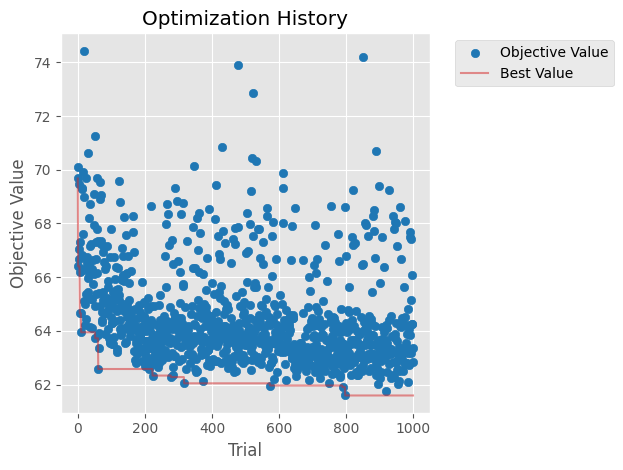

/var/folders/_1/31ptxk6d3nn4qzvtp4ln67dw0000gn/T/ipykernel_3017/3560253982.py:31: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Figure size 1000x600 with 0 Axes>

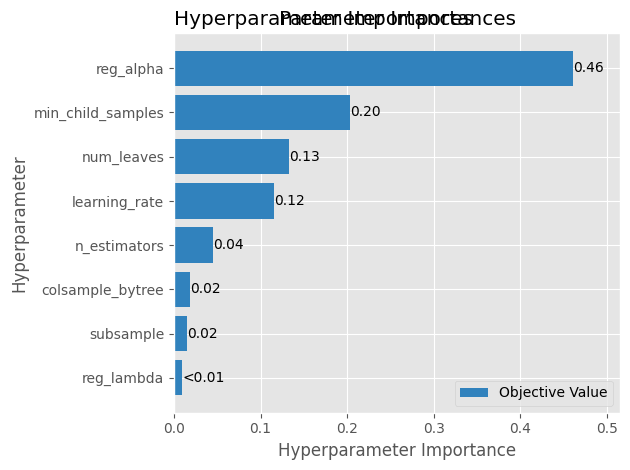

In [69]:
best_params = study.best_params
best_lgbm = lgb.LGBMRegressor(**best_params)

best_regr = TransformedTargetRegressor(
    regressor=best_lgbm,
    transformer=transformer
)

best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_regr)
])

best_pipeline.fit(X_train, y_train)

val_X = val_df[features]
val_y = val_df[target]

val_predictions = best_pipeline.predict(val_X)
val_rmse = np.sqrt(mean_squared_error(val_y, val_predictions))

print(f"Validation RMSE: {val_rmse}")

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importances")
plt.tight_layout()
plt.show()

In [70]:
optuna.visualization.plot_slice(study)